<h1>Scraping the required table from WIKI page and Creating a cleaned Data Frame excluding the Not Assigned values

In [17]:
import pandas as pd
import numpy as np
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [18]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)

In [19]:
soup = BeautifulSoup(html, 'lxml')
type(soup)

bs4.BeautifulSoup

In [20]:
table = soup.find('table', class_='wikitable sortable')

In [21]:
A=[]
B=[]
C=[]
for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))


In [22]:
df=pd.DataFrame(A,columns=['Postal Code'])
df['Borough']=B
df['Neighborhood']=C
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [23]:
df.replace(r'\n', '', regex = True, inplace = True)

In [24]:
df.loc[2,'Borough']

'North York'

In [25]:
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [26]:
#Trying to find if any duplicates in Postal Code to merge their Neighborhood
df[df['Postal Code'].duplicated()]

,Postal Code,Borough,Neighborhood


In [27]:
df.shape

(103, 3)

<h1> Created the Dataframe with Geo Spatial

In [28]:
df_geo_CourseraFile=pd.read_csv('https://cocl.us/Geospatial_data')

df_geo_CourseraFile.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [29]:
df_Geo = pd.merge(df, df_geo_CourseraFile, on='Postal Code')

df_Geo.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [36]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [37]:
address = 'Toronto City, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto City are 43.6534817, -79.3839347.


<h3>Create map of Toronto using latitude and longitude values

In [38]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Geo['Latitude'], df_Geo['Longitude'], df_Geo['Borough'], df_Geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h3>Going to work only with the Borough that contain the word Toronto

In [39]:
tor_str_df = df_Geo[df_Geo['Borough'].str.contains("Toronto")].reset_index(drop=True)
tor_str_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


<h3>Creating a Map just with the Borough that contain word Toronto

In [40]:
# create map of Manhattan using latitude and longitude values
map_tor_str = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(tor_str_df['Latitude'], tor_str_df['Longitude'], tor_str_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor_str)  
map_tor_str

<h3>Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Let's explore the first neighborhood in our dataframe.

In [41]:
tor_str_df.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

In [42]:
CLIENT_ID = 'QPWXLRWVAPBWUJ23Z3HIEP1QWVYKVIMJ0WLUOMIQR0M2OUIF' # your Foursquare ID
CLIENT_SECRET = 'LZQWQZBGPEWCA0JTBFW4GZTAXEMGHY03HQZF3OLQL0DVQNSM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [43]:
neighborhood_latitude = tor_str_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = tor_str_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = tor_str_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


In [44]:
LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=QPWXLRWVAPBWUJ23Z3HIEP1QWVYKVIMJ0WLUOMIQR0M2OUIF&client_secret=LZQWQZBGPEWCA0JTBFW4GZTAXEMGHY03HQZF3OLQL0DVQNSM&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [45]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee32df7226d4f12e8beb1e5'},
 'response': {'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 46,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.653446723052674,
          'lng': -79.3620167174383}],
        'distance': 143,
       

In [46]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [47]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
3,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [48]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

46 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
tor_str_venues = getNearbyVenues(names=tor_str_df['Neighborhood'],
                                   latitudes=tor_str_df['Latitude'],
                                   longitudes=tor_str_df['Longitude']
                                )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [51]:
print(tor_str_venues.shape)
tor_str_venues.head()

(1618, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [52]:
tor_str_venues.loc[tor_str_venues['Neighborhood']=='Christie']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
381,Christie,43.669542,-79.422564,Fiesta Farms,43.668471,-79.420485,Grocery Store
382,Christie,43.669542,-79.422564,Contra Cafe,43.669107,-79.426105,Café
383,Christie,43.669542,-79.422564,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
384,Christie,43.669542,-79.422564,Starbucks,43.671530,-79.421400,Coffee Shop
385,Christie,43.669542,-79.422564,Scout and Cash Caffe,43.667360,-79.419938,Café
386,Christie,43.669542,-79.422564,Universal Grill,43.670550,-79.426541,Diner
387,Christie,43.669542,-79.422564,Faema Caffe,43.671046,-79.419297,Café
388,Christie,43.669542,-79.422564,Actinolite,43.667858,-79.428054,Restaurant
389,Christie,43.669542,-79.422564,Stubbe Chocolates,43.671566,-79.421289,Candy Store
390,Christie,43.669542,-79.422564,Loblaws,43.671657,-79.421364,Grocery Store


In [53]:
tor_str_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",18,18,18,18,18,18
Central Bay Street,65,65,65,65,65,65
Christie,16,16,16,16,16,16
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,31,31,31,31,31,31


In [54]:
print('There are {} uniques categories.'.format(len(tor_str_venues['Venue Category'].unique())))

There are 237 uniques categories.


## 3. Analyze Each Neighborhood

In [55]:
# one hot encoding
tor_str_onehot = pd.get_dummies(tor_str_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_str_onehot['Neighborhood'] = tor_str_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_str_onehot.columns[-1]] + list(tor_str_onehot.columns[:-1])
tor_str_onehot = tor_str_onehot[fixed_columns]

tor_str_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [56]:
tor_str_onehot.shape

(1618, 237)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [57]:
tor_str_grouped = tor_str_onehot.groupby('Neighborhood').mean().reset_index()
tor_str_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.0000,0.017857,0.0000,0.017857,0.035714,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.0000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.017857,0.053571,0.071429,0.000000,0.00000,0.000000,0.00,0.000000,0.017857,0.000000,0.017857,0.000000,0.00,0.000000,0.00000,0.017857,0.000000,0.000000,0.0

In [58]:
tor_str_grouped.shape

(39, 237)

In [59]:
num_top_venues = 5

for hood in tor_str_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tor_str_grouped[tor_str_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1     Coffee Shop  0.09
2  Breakfast Spot  0.09
3          Bakery  0.09
4             Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0           Yoga Studio  0.06
1         Auto Workshop  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4                Garden  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3             Plane  0.06
4          Boutique  0.06


----Central Bay Street----
                 venue  freq
0      

First, let's write a function to sort the venues in descending order.

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_str_grouped['Neighborhood']

for ind in np.arange(tor_str_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_str_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Café,Cheese Shop,Beer Bar,Restaurant,Seafood Restaurant,Pub,Creperie
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Coffee Shop,Breakfast Spot,Grocery Store,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Park,Pizza Place,Restaurant,Butcher,Burrito Place,Brewery,Skate Park,Light Rail Station
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boutique,Rental Car Location,Plane,Coffee Shop,Boat or Ferry,Harbor / Marina,Airport Gate
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place,Burger Joint,Department Store,Salad Place,Bubble Tea Shop,Yoga Studio


## 4. Cluster Neighborhoods

In [62]:
# set number of clusters
kclusters = 5

tor_str_grouped_clustering = tor_str_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_str_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 4, 0, 0, 0, 0], dtype=int32)

In [63]:
tor_str_grouped_clustering.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.017857,0.000000,0.0,0.0,0.0000,0.017857,0.0,0.017857,0.035714,0.0,0.000000,0.0,0.017857,0.017857,0.0,0.035714,0.0,0.0,0.017857,0.000000,0.0,0.000000,0.0,0.017857,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.035714,0.0,0.0,0.0,0.0,0.035714,0.000000,0.0,0.0,0.000000,0.017857,0.053571,0.071429,0.0,0.0,0.0,0.0,0.0,0.017857,0.000000,0.017857,0.000000,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.017857,0.000000,0.0,0.017857,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017857,0.0,0.0,0.0,0.000000,0.017857,0.0000,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.0,0.0,0.017857,0

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [64]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = tor_str_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tor_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Restaurant,Breakfast Spot,Café,Theater,Hotel,Dessert Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Diner,Bakery
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Cocktail Bar,American Restaurant,Gastropub,Restaurant,Clothing Store,Moroccan Restaurant,Cosmetics Shop,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store


In [65]:
#tor_merged['Cluster Labels'].groupby('Borough','CLuster Labels').value_counts()

tor_merged.groupby('Borough')['Cluster Labels'].value_counts()

Borough           Cluster Labels
Central Toronto   0                  6
                  1                  1
                  2                  1
                  3                  1
Downtown Toronto  0                 17
                  3                  1
                  4                  1
East Toronto      0                  5
West Toronto      0                  6
Name: Cluster Labels, dtype: int64

Finally, let's visualize the resulting clusters

In [66]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [80]:
cluster4=tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Restaurant,Breakfast Spot,Café,Theater,Hotel,Dessert Shop
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Bubble Tea Shop,Café,Japanese Restaurant,Italian Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Diner,Bakery
3,Downtown Toronto,0,Café,Coffee Shop,Cocktail Bar,American Restaurant,Gastropub,Restaurant,Clothing Store,Moroccan Restaurant,Cosmetics Shop,Creperie
4,East Toronto,0,Trail,Health Food Store,Pub,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Bakery,Café,Cheese Shop,Beer Bar,Restaurant,Seafood Restaurant,Pub,Creperie
6,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Japanese Restaurant,Sandwich Place,Burger Joint,Department Store,Salad Place,Bubble Tea Shop,Yoga Studio
8,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Hotel,Deli / Bodega,Gym,Clothing Store,Thai Restaurant,Salad Place,Concert Hall
9,West Toronto,0,Bakery,Pharmacy,Bank,Bar,Middle Eastern Restaurant,Café,Supermarket,Grocery Store,Pet Store,Music Venue
10,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Café,Restaurant,Brewery,Sporting Goods Shop,Scenic Lookout,Fried Chicken Joint,Italian Restaurant


In [81]:
cluster1=tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster1

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,1,Ice Cream Shop,Home Service,Garden,Women's Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [86]:
cluster5=tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster5

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,Park,Swim School,Bus Line,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [83]:
cluster2=tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,3,Park,Gym,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
33,Downtown Toronto,3,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


In [84]:
cluster3=tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]
cluster3

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Downtown Toronto,4,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Diner,Baby Store,Restaurant,Coffee Shop,Nightclub


In [87]:
c5=cluster5.set_index('Borough')
cluster5test=c5.transpose()
cluster5test.columns
cluster5test

Borough,Central Toronto
Cluster Labels,2
1st Most Common Venue,Park
2nd Most Common Venue,Swim School
3rd Most Common Venue,Bus Line
4th Most Common Venue,Dim Sum Restaurant
5th Most Common Venue,Event Space
6th Most Common Venue,Ethiopian Restaurant
7th Most Common Venue,Electronics Store
8th Most Common Venue,Eastern European Restaurant
9th Most Common Venue,Dumpling Restaurant


In [88]:
a5 = cluster5test[cluster5test['Central Toronto'].str.contains('Restaurant',na=False)].groupby('Central Toronto').size()
a5
CTc5RestaurantCount = a5.apply(lambda x: 1).sum()
CTc5RestaurantCount

4

In [89]:
#Setting Borough as Index and transposing the table to count the number of restaurants for each Borough in this cluster
c4=cluster4.set_index('Borough')
cluster4test=c4.transpose()
cluster4test.columns
cluster4test.head()

Borough,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,East Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,West Toronto,Downtown Toronto,West Toronto,East Toronto,Downtown Toronto,West Toronto,East Toronto,Downtown Toronto,East Toronto,Central Toronto,Central Toronto,West Toronto,Central Toronto,Central Toronto,West Toronto,Central Toronto,Downtown Toronto,West Toronto,Downtown Toronto,Central Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,East Toronto
Cluster Labels,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1st Most Common Venue,Coffee Shop,Coffee Shop,Clothing Store,Café,Trail,Coffee Shop,Coffee Shop,Coffee Shop,Bakery,Coffee Shop,Bar,Greek Restaurant,Coffee Shop,Café,Fast Food Restaurant,Coffee Shop,Café,Park,Jewelry Store,Thai Restaurant,Clothing Store,Café,Gift Shop,Dessert Shop,Café,Coffee Shop,Café,Pub,Airport Service,Coffee Shop,Café,Coffee Shop,Coffee Shop,Yoga Studio
2nd Most Common Venue,Bakery,Sushi Restaurant,Coffee Shop,Coffee Shop,Health Food Store,Cocktail Bar,Café,Café,Pharmacy,Aquarium,Asian Restaurant,Coffee Shop,Hotel,Bakery,Sandwich Place,Café,Coffee Shop,Pizza Place,Trail,Mexican Restaurant,Coffee Shop,Sandwich Place,Breakfast Spot,Sandwich Place,Bar,Sushi Restaurant,Coffee Shop,Light Rail Station,Airport Terminal,Café,Coffee Shop,Café,Sushi Restaurant,Auto Workshop
3rd Most Common Venue,Park,Yoga Studio,Bubble Tea Shop,Cocktail Bar,Pub,Bakery,Italian Restaurant,Restaurant,Bank,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Café,Coffee Shop,Steakhouse,Restaurant,Brewery,Breakfast Spot,Sushi Restaurant,Café,Yoga Studio,Coffee Shop,Restaurant,Sushi Restaurant,Italian Restaurant,Café,Mexican Restaurant,Coffee Shop,Airport Lounge,Italian Restaurant,Pizza Place,Hotel,Japanese Restaurant,Park
4th Most Common Venue,Pub,Bank,Café,American Restaurant,Doner Restaurant,Café,Japanese Restaurant,Hotel,Bar,Café,Restaurant,Restaurant,Restaurant,Breakfast Spot,Restaurant,Hotel,Gastropub,Sandwich Place,Mexican Restaurant,Furniture / Home Store,Sporting Goods Shop,Grocery Store,Cuban Restaurant,Coffee Shop,Japanese Restaurant,Pub,Vietnamese Restaurant,American Restaurant,Boutique,Seafood Restaurant,Restaurant,Gym,Restaurant,Pizza Place


In [90]:
#Concatenating all the venues based on Duplicate columns of Boroughs

cluster4test['DTcombined'] = cluster4test[['Downtown Toronto']].astype(str).apply(','.join, axis=1)
cluster4test['CTcombined'] = cluster4test[['Central Toronto']].astype(str).apply(','.join, axis=1)
cluster4test['ETcombined'] = cluster4test[['East Toronto']].astype(str).apply(','.join, axis=1)
cluster4test['WTcombined'] = cluster4test[['West Toronto']].astype(str).apply(','.join, axis=1)
cluster4test.head()

Borough,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,East Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,West Toronto,Downtown Toronto,West Toronto,East Toronto,Downtown Toronto,West Toronto,East Toronto,Downtown Toronto,East Toronto,Central Toronto,Central Toronto,West Toronto,Central Toronto,Central Toronto,West Toronto,Central Toronto,Downtown Toronto,West Toronto,Downtown Toronto,Central Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,Downtown Toronto,East Toronto,DTcombined,CTcombined,ETcombined,WTcombined
Cluster Labels,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0","0,0,0,0,0,0","0,0,0,0,0","0,0,0,0,0,0"
1st Most Common Venue,Coffee Shop,Coffee Shop,Clothing Store,Café,Trail,Coffee Shop,Coffee Shop,Coffee Shop,Bakery,Coffee Shop,Bar,Greek Restaurant,Coffee Shop,Café,Fast Food Restaurant,Coffee Shop,Café,Park,Jewelry Store,Thai Restaurant,Clothing Store,Café,Gift Shop,Dessert Shop,Café,Coffee Shop,Café,Pub,Airport Service,Coffee Shop,Café,Coffee Shop,Coffee Shop,Yoga Studio,"Coffee Shop,Coffee Shop,Clothing Store,Café,Co...","Park,Jewelry Store,Clothing Store,Café,Dessert...","Trail,Greek Restaurant,Fast Food Restaurant,Ca...","Bakery,Bar,Café,Thai Restaurant,Gift Shop,Coff..."
2nd Most Common Venue,Bakery,Sushi Restaurant,Coffee Shop,Coffee Shop,Health Food Store,Cocktail Bar,Café,Café,Pharmacy,Aquarium,Asian Restaurant,Coffee Shop,Hotel,Bakery,Sandwich Place,Café,Coffee Shop,Pizza Place,Trail,Mexican Restaurant,Coffee Shop,Sandwich Place,Breakfast Spot,Sandwich Place,Bar,Sushi Restaurant,Coffee Shop,Light Rail Station,Airport Terminal,Café,Coffee Shop,Café,Sushi Restaurant,Auto Workshop,"Bakery,Sushi Restaurant,Coffee Shop,Coffee Sho...","Pizza Place,Trail,Coffee Shop,Sandwich Place,S...","Health Food Store,Coffee Shop,Sandwich Place,C...","Pharmacy,Asian Restaurant,Bakery,Mexican Resta..."
3rd Most Common Venue,Park,Yoga Studio,Bubble Tea Shop,Cocktail Bar,Pub,Bakery,Italian Restaurant,Restaurant,Bank,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Café,Coffee Shop,Steakhouse,Restaurant,Brewery,Breakfast Spot,Sushi Restaurant,Café,Yoga Studio,Coffee Shop,Restaurant,Sushi Restaurant,Italian Restaurant,Café,Mexican Restaurant,Coffee Shop,Airport Lounge,Italian Restaurant,Pizza Place,Hotel,Japanese Restaurant,Park,"Park,Yoga Studio,Bubble Tea Shop,Cocktail Bar,...","Breakfast Spot,Sushi Restaurant,Yoga Studio,Co...","Pub,Italian Restaurant,Steakhouse,Brewery,Park","Bank,Vegetarian / Vegan Restaurant,Coffee Shop..."
4th Most Common Venue,Pub,Bank,Café,American Restaurant,Doner Restaurant,Café,Japanese Restaurant,Hotel,Bar,Café,Restaurant,Restaurant,Restaurant,Breakfast Spot,Restaurant,Hotel,Gastropub,Sandwich Place,Mexican Restaurant,Furniture / Home Store,Sporting Goods Shop,Grocery Store,Cuban Restaurant,Coffee Shop,Japanese Restaurant,Pub,Vietnamese Restaurant,American Restaurant,Boutique,Seafood Restaurant,Restaurant,Gym,Restaurant,Pizza Place,"Pub,Bank,Café,American Restaurant,Café,Japanes...","Sandwich Place,Mexican Restaurant,Sporting Goo...","Doner Restaurant,Restaurant,Restaurant,Gastrop...","Bar,Restaurant,Breakfast Spot,Furniture / Home..."


In [91]:
a4 = cluster4test[cluster4test['DTcombined'].str.contains('Restaurant',na=False)].groupby('DTcombined').size()
a4
DTc4RestaurantCount = a4.apply(lambda x: 1).sum()
DTc4RestaurantCount

b4 = cluster4test[cluster4test['CTcombined'].str.contains('Restaurant',na=False)].groupby('CTcombined').size()
CTc4RestaurantCount = b4.apply(lambda x: 1).sum()
CTc4RestaurantCount

c4 = cluster4test[cluster4test['ETcombined'].str.contains('Restaurant',na=False)].groupby('ETcombined').size()
ETc4RestaurantCount = c4.apply(lambda x: 1).sum()
ETc4RestaurantCount

d4 = cluster4test[cluster4test['WTcombined'].str.contains('Restaurant',na=False)].groupby('WTcombined').size()
WTc4RestaurantCount = d4.apply(lambda x: 1).sum()
WTc4RestaurantCount



print('Number of Restaurants in each Borough in CLuster 4 are: Downtown Toronto {}, Central Toronto {}, East Toronto {}, West Toronto {}.'.format(DTc4RestaurantCount, CTc4RestaurantCount, ETc4RestaurantCount, WTc4RestaurantCount))

Number of Restaurants in each Borough in CLuster 4 are: Downtown Toronto 9, Central Toronto 8, East Toronto 7, West Toronto 10.


In [92]:
#Setting Borough as Index and transposing the table to count the number of restaurants for each Borough in this cluster
c3=cluster3.set_index('Borough')
cluster3test=c3.transpose()
cluster3test.columns
cluster3test.head()

Borough,Downtown Toronto
Cluster Labels,4
1st Most Common Venue,Grocery Store
2nd Most Common Venue,Café
3rd Most Common Venue,Park
4th Most Common Venue,Candy Store


In [93]:
#Count number of restaurants for each Borough
a3 = cluster3test[cluster3test['Downtown Toronto'].str.contains('Restaurant',na=False)].groupby('Downtown Toronto').size()
CTc3RestaurantCount = a3.apply(lambda x: 1).sum()
CTc3RestaurantCount


2

In [94]:
#Setting Borough as Index and transposing the table to count the number of restaurants for each Borough in this cluster 
c2=cluster2.set_index('Borough')
cluster2test=c2.transpose()
cluster2test.columns
cluster2test.head()


#Count number of restaurants for each Borough
a2 = cluster2test[cluster2test['Central Toronto'].str.contains('Restaurant',na=False)].groupby('Central Toronto').size()
CTc2RestaurantCount = a2.apply(lambda x: 1).sum()
print('Cluster 2 Central Toronto Restaurants:',CTc2RestaurantCount)

b2 = cluster2test[cluster2test['Downtown Toronto'].str.contains('Restaurant',na=False)].groupby('Downtown Toronto').size()
DTc2RestaurantCount = b2.apply(lambda x: 1).sum()
print('Cluster 2 Downtown Toronto Restaurants:',DTc2RestaurantCount)

Cluster 2 Central Toronto Restaurants: 4
Cluster 2 Downtown Toronto Restaurants: 4


In [96]:
#Setting Borough as Index and transposing the table to count the number of restaurants for each Borough in this cluster 
c1=cluster1.set_index('Borough')
cluster1test=c1.transpose()
cluster1test.columns
cluster1test.head()


#Count number of restaurants for each Borough
a1 = cluster1test[cluster1test['Central Toronto'].str.contains('Restaurant',na=False)].groupby('Central Toronto').size()
CTc1RestaurantCount = a1.apply(lambda x: 1).sum()
print('Cluster 1 Central Toronto Restaurants:',CTc1RestaurantCount)



Cluster 1 Central Toronto Restaurants: 3


In [98]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [['Central Toronto', CTc1RestaurantCount,CTc2RestaurantCount, CTc3RestaurantCount,CTc4RestaurantCount,CTc5RestaurantCount], ['East Toronto', 0,0,0,ETc4RestaurantCount,0],['Downtown Toronto',0, DTc2RestaurantCount,0,DTc4RestaurantCount,0],['West Toronto',0,0,0,WTc4RestaurantCount,0]]


  
# Create the pandas DataFrame 
dftest1 = pd.DataFrame(data, columns = ['Borough', 'Cluster1','Cluster2','Cluster3','Cluster4','Cluster5']) 
  
# print dataframe. 
dftest1

,Borough,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5
0,Central Toronto,3,4,2,8,4
1,East Toronto,0,0,0,7,0
2,Downtown Toronto,0,4,0,9,0
3,West Toronto,0,0,0,10,0


In [99]:
dftest1.plot(x="Borough", y=["Cluster1","Cluster2","Cluster3","Cluster4","Cluster5"], kind="bar")

Matplotlib version:  3.0.2


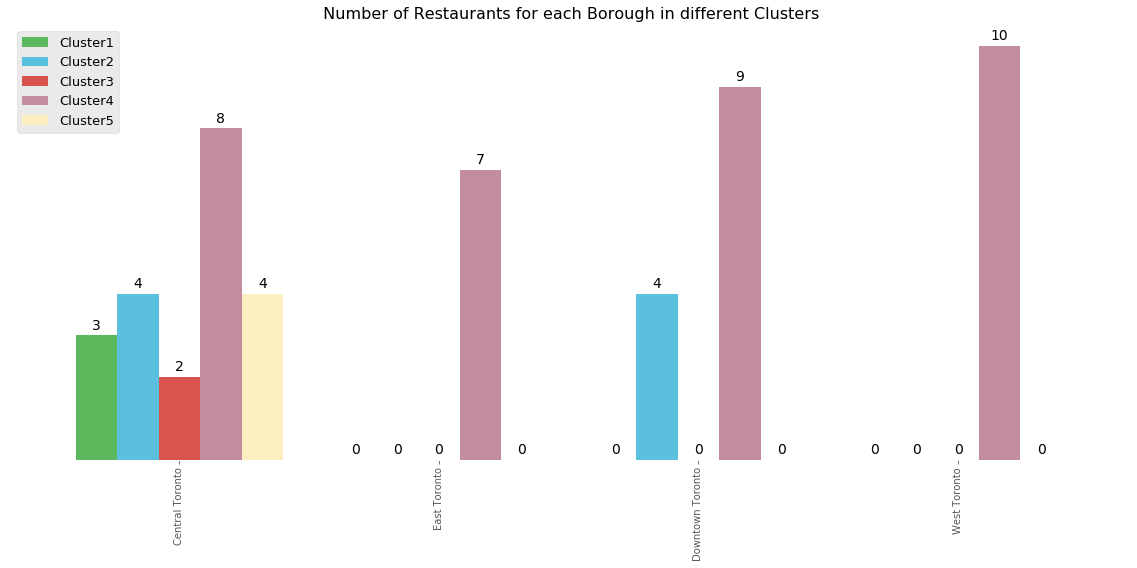

In [102]:
dftest1=dftest1.set_index('Borough')

import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0





ax = dftest1.plot(kind='bar', figsize=(20,8), color= ['#5cb85c','#5bc0de','#d9534f','#c38d9e','#fbeec1'], width = 0.8)


plt.xlabel('') # add to x-label to the plot
plt.ylabel('') # add y-label to the plot
plt.title(' Number of Restaurants for each Borough in different Clusters',fontsize=16) # add title to the plot
plt.legend(("Cluster1","Cluster2","Cluster3","Cluster4","Cluster5"),fontsize=13)



# Removing the Border  
ax.set_facecolor('white')
ax.get_yaxis().set_visible(False)

# Creating a function to display the percentagee

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )
        


plt.show()